In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os


data = []
labels = []
IMG_SIZE = 130
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Train'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Train/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    data.append(img)
    labels.append(i.split('_')[0])

print(len(data))
print(labels[0])

1681
Yoga


# Preprocessing

In [89]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = np_utils.to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

1344
337


# Data Augmentation

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
val_datagen = ImageDataGenerator()
train_gen = train_datagen.flow(trainX,trainY,batch_size=32)
val_gen = val_datagen.flow(testX,testY,batch_size=32)

# Model

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model = Sequential()
# l2 = tf.keras.regularizers.l2(0.0001)
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))

In [94]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 12, 12, 64)      

In [95]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early = EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=1,mode='auto')


hist = model.fit(train_gen,epochs=400,validation_data=val_gen,callbacks=[checkpoint,early])

Epoch 1/400
135/135 [==============================] - 22s 156ms/step - loss: 1.7455 - accuracy: 0.3118 - val_loss: 1.6066 - val_accuracy: 0.3947

Epoch 00001: val_loss improved from inf to 1.60658, saving model to model.h5
Epoch 2/400
135/135 [==============================] - 20s 148ms/step - loss: 1.5096 - accuracy: 0.4539 - val_loss: 1.4705 - val_accuracy: 0.4540

Epoch 00002: val_loss improved from 1.60658 to 1.47050, saving model to model.h5
Epoch 3/400
135/135 [==============================] - 20s 152ms/step - loss: 1.3945 - accuracy: 0.4903 - val_loss: 1.3060 - val_accuracy: 0.5015

Epoch 00003: val_loss improved from 1.47050 to 1.30600, saving model to model.h5
Epoch 4/400
135/135 [==============================] - 21s 153ms/step - loss: 1.3106 - accuracy: 0.5149 - val_loss: 1.3300 - val_accuracy: 0.5104

Epoch 00004: val_loss did not improve from 1.30600
Epoch 5/400
135/135 [==============================] - 21s 152ms/step - loss: 1.2388 - accuracy: 0.5499 - val_loss: 1.2081

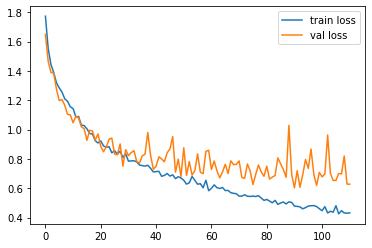

In [75]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Evaluation

In [76]:
model.evaluate(testX,testY)

11/11 [==============================] - 1s 80ms/step - loss: 0.6279 - accuracy: 0.8190


[0.6278781890869141, 0.8189911246299744]

# Reading Test Data

In [77]:
test_data = []
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Test'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Test/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    test_data.append(np.array(img))
test_data = np.array(test_data)
test_data = test_data/255.0

print(len(test_data))

688


# Predictions

In [81]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)
# pred = le.inverse_transform(pred)
df = pd.DataFrame({'image_name':os.listdir('/kaggle/input/nn23-sports-image-classification/Test'),'Label':pred})
df.to_csv('submission.csv',index=False)
df

,image_name,Label
0,623.jpg,1
1,208.jpg,5
2,473.jpg,0
3,333.jpg,1
4,537.jpg,1
...,...,...
683,364.jpg,2
684,90.jpg,3
685,599.jpg,2
686,25.jpg,4


In [79]:
model.save('model.h5')
import pickle
f = open('label_encoder.pkl', "wb")
f.write(pickle.dumps(le))
f.close()